## Agentic RAG

In [1]:
import os
import warnings
from dotenv import load_dotenv

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
warnings.filterwarnings("ignore")

load_dotenv('../.env')

True

In [2]:
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI

# model = "llama3.2:3b"
model = "qwen2.5"

# llm = ChatOllama(model=model, base_url="http://localhost:11434")
llm = ChatOpenAI(model="gpt-4o-mini")
output = llm.invoke("Hello, how are you?.")
output

AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 13, 'total_tokens': 44, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-69784de8-2250-48a2-bc0e-74407d6e1b26-0', usage_metadata={'input_tokens': 13, 'output_tokens': 31, 'total_tokens': 44, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [3]:
import re

# Regex to remove <think> and <thinking> blocks
regex = r"<think>.*?<\/think>|<thinking>.*?<\/thinking>"

# Remove matching content
cleaned_text = re.sub(regex, "", output.content, flags=re.DOTALL)

print(cleaned_text)

Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?


## Retriever

In [4]:
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import FAISS 


db_name = "../00 Dataset/vector_db/"
embeddigs = OllamaEmbeddings(model="nomic-embed-text", base_url="http://localhost:11434")

vector_store = FAISS.load_local(db_name, embeddigs, allow_dangerous_deserialization=True)

question = "What is the revenue of Facebook in 2024?"

# retriever = vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 3})

# retriever.invoke(question, filter = {'company': 'facebook'})

In [5]:
import re
from typing import List, Dict, Any, Optional
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from pydantic import Field, BaseModel
from langchain_community.vectorstores import FAISS
import json
from utils import get_filter
from query_filter import get_query_filter

from langchain.tools import tool

# Step 1: Define the Custom Retriever
class FilterableRetriever(BaseRetriever):
    """Custom retriever with query and filter support
    
    args:
    query: str - The query to search for
    filter: dict - The filter to apply to the search
    """
    
    vector_store: FAISS = Field(...)  # Properly declare the field using Pydantic

    def _get_relevant_documents(
        self,
        query: str,
        *,
        run_manager: CallbackManagerForRetrieverRun = None,
        **kwargs
    ) -> List[Document]:
        """Main retrieval method with filter support"""
        try:
            filter = get_query_filter(query)
            print(f"\n\n\nQuery: {query}\nFilter: {filter}\n\n\n")
            return self.vector_store.similarity_search(
                query=query,
                filter=filter,
                k=5  # Number of documents to retrieve
            )
        except Exception as e:
            print(f"Retrieval error: {e}")
            return []


d:\LLM\Agentic RAG with LangChain and LangGraph\08. Agentic RAG\query_filter.py:19: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = ChatOllama(model=model, base_url="http://localhost:11434")


{'company': 'apple'}


In [6]:
document_retriever = FilterableRetriever(vector_store=vector_store)

document_retriever.invoke(question, filter = {'company': 'facebook'})




Query: What is the revenue of Facebook in 2024?
Filter: {'company': 'facebook'}





[Document(id='64911e66-51e1-4006-953f-40808cd55599', metadata={'Header 2': 'CFO Outlook Commentary', 'company': 'facebook'}, page_content='## CFO Outlook Commentary  \nWe expect fourth quarter 2024 total revenue to be in the range of $45-48 billion. Our guidance assumes foreign currency is approximately neutral to year-over-year total revenue growth, based on current exchange rates.  \nWe expect full-year 2024 total expenses to be in the range of $96-98 billion, updated from our prior range of $96-99 billion. For Reality Labs, we continue to expect 2024 operating losses to increase meaningfully year-over-year due to our ongoing product development efforts and investments to further scale our ecosystem.  \nWe anticipate our full-year 2024 capital expenditures will be in the range of $38-40 billion, updated from our prior range of $37-40  billion.  We  continue  to  expect  significant  capital  expenditures  growth  in  2025.  Given  this,  along  with  the  back-end weighted nature of 

In [7]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.runnables import RunnableLambda


retriever_tool = create_retriever_tool(
    document_retriever,
    "analyst",
    "Search and return information about the financials of a company",
)

In [8]:
@tool
def analyst(query: str, company: str) -> Optional[str]:
    """Search and return information about the financials of a company
    args:
    query: str - The question to ask
    company: str - The company in lowercase to search for
    """
    return document_retriever.invoke(query, filter = {'company': company})


tools = [analyst]

# analyst.invoke({"query":"What is the revenue of Google in September 2024?","company":"google"})

In [9]:
tools

[StructuredTool(name='analyst', description='Search and return information about the financials of a company\n    args:\n    query: str - The question to ask\n    company: str - The company in lowercase to search for', args_schema=<class 'langchain_core.utils.pydantic.analyst'>, func=<function analyst at 0x0000017A47357A60>)]

## Agent

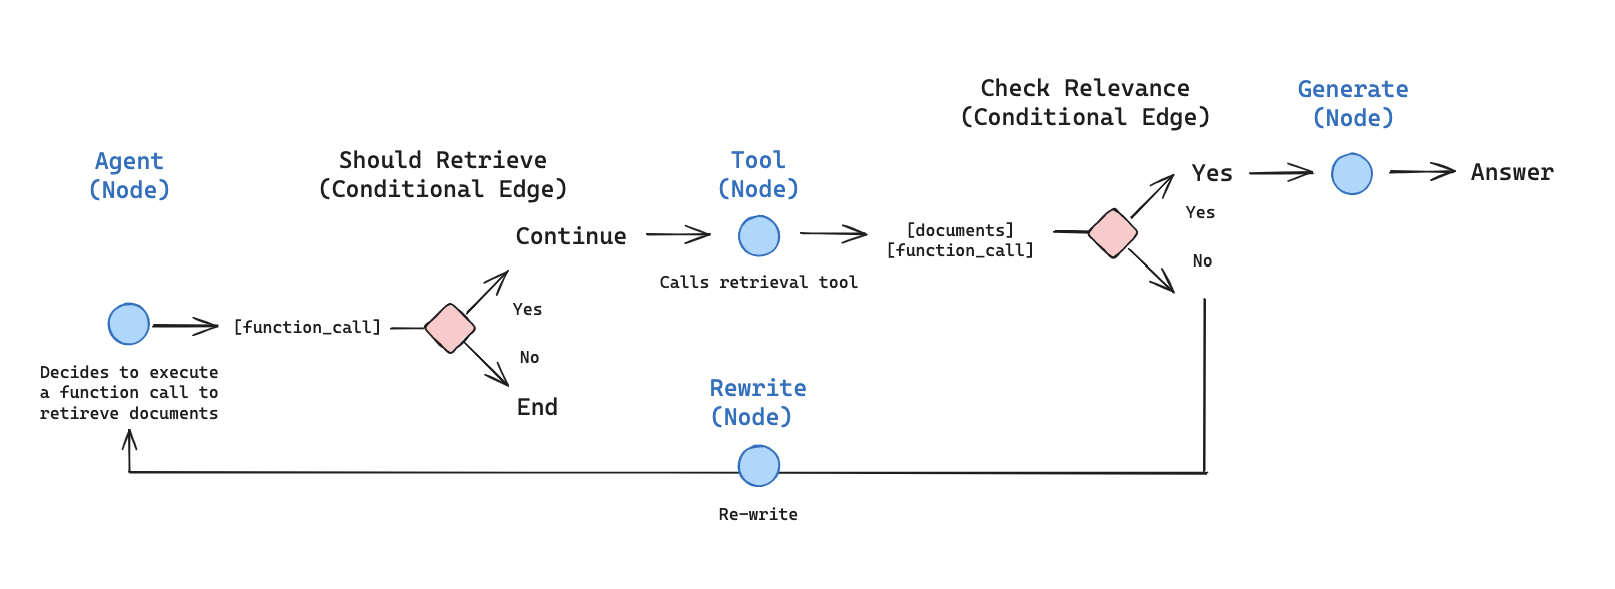

We can lay out an agentic RAG graph like this:

- The state is a set of messages
- Each node will update (append to) state
- Conditional edges decide which node to visit next

In [10]:
from typing import Annotated, Sequence, TypedDict 
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import tools_condition

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

### Agent Node

In [11]:
tools

[StructuredTool(name='analyst', description='Search and return information about the financials of a company\n    args:\n    query: str - The question to ask\n    company: str - The company in lowercase to search for', args_schema=<class 'langchain_core.utils.pydantic.analyst'>, func=<function analyst at 0x0000017A47357A60>)]

In [12]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]

    llm_with_tools = llm.bind_tools(tools, tool_choice="required")
    response = llm_with_tools.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [13]:
state = {'messages': [HumanMessage(content="What is the revenue of Facebook in 2024?")]}
agent(state)

---CALL AGENT---


{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_QVWv4dMmUapWPZPZSCsjhRdI', 'function': {'arguments': '{"query":"What is the revenue forecast for 2024?","company":"facebook"}', 'name': 'analyst'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 88, 'total_tokens': 117, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-dfb9e501-b771-4a4e-b28b-1ba93bcc257b-0', tool_calls=[{'name': 'analyst', 'args': {'query': 'What is the revenue forecast for 2024?', 'company': 'facebook'}, 'id': 'call_QVWv4dMmUapWPZPZSCsjhRdI', 'type': 'tool_call'}], usage_metadata={'input_tokens': 88, 'output_tokens': 29, 'total_t

In [14]:
tools

[StructuredTool(name='analyst', description='Search and return information about the financials of a company\n    args:\n    query: str - The question to ask\n    company: str - The company in lowercase to search for', args_schema=<class 'langchain_core.utils.pydantic.analyst'>, func=<function analyst at 0x0000017A47357A60>)]

### Graph
- Start with an agent, call_model
- Agent make a decision to call a function
- If so, then action to call tool (retriever)
- Then call agent with the tool output added to messages (state)

In [15]:
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode
from graph_nodes import grade_documents, rewrite, generate

In [16]:
graph_builder = StateGraph(State)

graph_builder.add_node("agent", agent)
retriever = ToolNode([retriever_tool])
graph_builder.add_node("retriever", retriever)
graph_builder.add_node("rewrite", rewrite)

graph_builder.add_node("generate", generate)


graph_builder.add_edge(START, "agent")

graph_builder.add_conditional_edges( 
    "agent",

    tools_condition,
    {
        "tools": "retriever",
        END: END
    }
)

graph_builder.add_conditional_edges(
    "retriever",
    grade_documents
)

graph_builder.add_edge("generate", END)
graph_builder.add_edge("rewrite", "agent")

graph = graph_builder.compile()

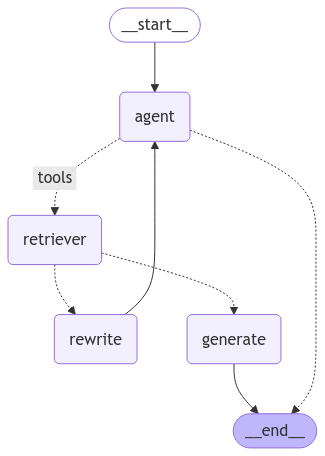

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
from pprint import pprint

query = {"messages": [HumanMessage("What is the revenue of facebook in 2024?")]}

# graph.invoke(query)

for output in graph.stream(query):
    for key, value in output.items():
        pprint(f"Output from node '{key}':")
        pprint("----")
        pprint(value, indent=4, width=120)

    pprint("\n------\n")

---CALL AGENT---
"Output from node 'agent':"
'----'
{   'messages': [   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tlqDkIsBNUjAnddDOmnppCx8', 'function': {'arguments': '{"query":"What is the projected revenue for Facebook in 2024?","company":"facebook"}', 'name': 'analyst'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 88, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8fd3018f-18ab-4d48-852f-b3d24d51fd29-0', tool_calls=[{'name': 'analyst', 'args': {'query': 'What is the projected revenue for Facebook in 2024?', 'company': 'facebook'}, 'id': 'call_tlqDkIsBNUjAnddDOmnppCx8', 'typ